# Notebook Containing the data generation, NN Modelling and Optimization Attempts for two windturbines

In [1]:
### Imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

from pyomo import environ
from pyomo.core import *
import pyomo.environ as pyo
import gurobipy

import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), 'DistCL_code_modified'))
from distcl import distcl

## Load Data

In [2]:
# Load Data
data = pd.read_csv("data/two_turbine_simulation_data_var_wind_dir.csv")
data.head()

,x_turb2,y_turb2,wind_speed,wind_direction,turbulence_intensity,turbine1_power,turbine2_powers,farm_power
0,0.0,0.0,8.0,0.0,0.06,1753.954459,1753.954459,3507.908918
1,0.0,0.0,8.0,10.0,0.06,1753.954459,1753.954459,3507.908918
2,0.0,0.0,8.0,20.0,0.06,1753.954459,1753.954459,3507.908918
3,0.0,0.0,8.0,30.0,0.06,1753.954459,1753.954459,3507.908918
4,0.0,0.0,8.0,40.0,0.06,1753.954459,1753.954459,3507.908918


# Train NN and generate constraints

In [3]:
# Test/Train Split
train_data, temp_data = train_test_split(data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

val_ind = val_data.index
test_ind = test_data.index

In [18]:
# Retrain the model with the best parameters
cl_tool = distcl(X=data[["x_turb2", "y_turb2", "wind_speed", "wind_direction", "turbulence_intensity"]],#, "turbulence_intensity"]],
            y=data["farm_power"], n_preds=1, val_ind=val_ind, test_ind=test_ind)

model, preds_test, y_test = cl_tool.train(n_hidden=2, n_nodes=10, iters=1000, drop=0.05, learning_rate=1e-4)

DistFCNN(
  (lin_layers): ModuleList(
    (0): Linear(in_features=5, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
  )
  (output_mean_layer): Linear(in_features=10, out_features=1, bias=True)
  (droput_layers): ModuleList(
    (0-1): 2 x Dropout(p=0.05, inplace=False)
  )
)
cpu
epoch 0 loss 1.132102608680725


KeyboardInterrupt: 

In [ ]:
cons = cl_tool.constraint_build(model)
cons.to_csv('inputs/constraints_twoturbines.csv')
cons = pd.read_csv('inputs/constraints_twoturbines.csv', index_col=0)
cons

,intercept,layer,node,node_0,node_1,node_2,node_3,node_4,node_5,node_6,node_7,node_8,node_9
0,0.288687,0,0,-0.003348,0.171344,-0.368077,-0.389869,-0.172778,NaN,NaN,NaN,NaN,NaN
1,0.521581,0,1,0.119924,-0.028067,0.354591,-0.061639,0.059304,NaN,NaN,NaN,NaN,NaN
2,0.112951,0,2,-0.135154,-0.124622,-0.427245,-0.339217,-0.132288,NaN,NaN,NaN,NaN,NaN
3,0.125728,0,3,0.016566,0.185438,0.268338,-0.361698,-0.287046,NaN,NaN,NaN,NaN,NaN
4,0.418381,0,4,0.162436,0.377728,-0.092037,0.382247,-0.042173,NaN,NaN,NaN,NaN,NaN
5,-0.194389,0,5,0.047322,0.330713,-0.414867,-0.391132,-0.199069,NaN,NaN,NaN,NaN,NaN
6,0.024605,0,6,-0.174324,0.390358,-0.289875,-0.141008,-0.245059,NaN,NaN,NaN,NaN,NaN
7,-0.236902,0,7,-0.418843,-0.353689,0.384424,0.305293,0.185387,NaN,NaN,NaN,NaN,NaN
8,-0.236315,0,8,0.023520,-0.253813,0.075662,-0.534100,-0.359135,NaN,NaN,NaN,NaN,NaN
9,-0.220471,0,9,-0.230552,0.363170,0.262211,-0.160014,0.018105,NaN,NaN,NaN,NaN,NaN


# Optimization Model



### Decision Variables
\( x \): x-coordinate of the second turbine relative to the first.
\( y \): y-coordinate of the second turbine relative to the first.

### **Objective Function**
$$ \max_{x, y} P(x, y) $$

### Constraints
$ x_{\min} \leq x \leq x_{\max} $
   
$ y_{\min} \leq y \leq y_{\max} $


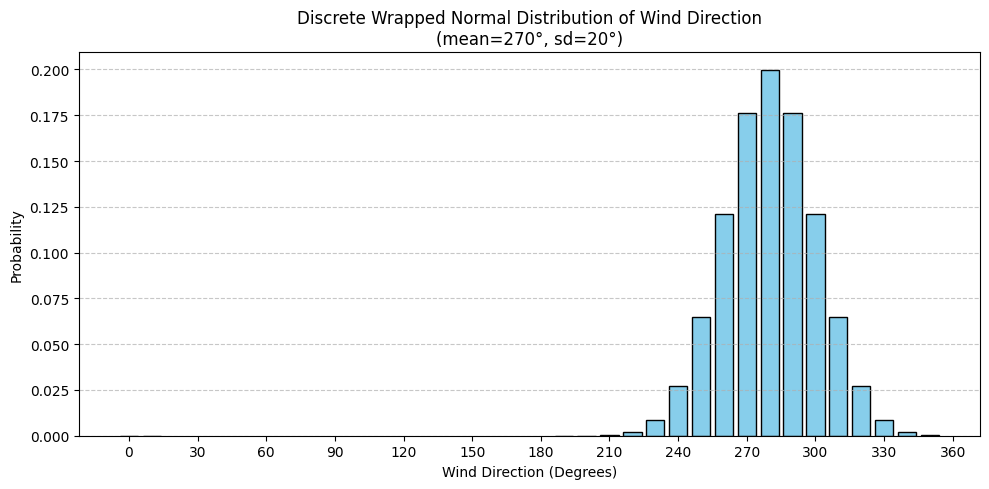

In [ ]:
# Generate distribution of wind directions
from scipy.stats import norm

# Parameters
mu = 280
sd = 20
angles = np.arange(0, 360, 10)

# Circular distance function
def circular_dist(x, mu):
    d = np.abs(x - mu) % 360
    return np.minimum(d, 360 - d)

# Apply normal PDF to circular distances
distances = circular_dist(angles, mu)
densities = norm.pdf(distances, loc=0, scale=sd)
probabilities = densities / np.sum(densities)

# Create DataFrame
wind_df = pd.DataFrame({
    'wind_direction': angles,
    'probability': np.round(probabilities, 5)
})

# add variables for correct format
wind_df = wind_df[wind_df['probability'] > 0].reset_index(drop=True)
wind_df.insert(0, 'x_turb2', np.nan)
wind_df.insert(1, 'y_turb2', np.nan)
wind_df['wind_speed'] = 8
wind_df['turbulence_intensity'] = 0.06

# Plot
plt.figure(figsize=(10, 5))
plt.bar(wind_df['wind_direction'], wind_df['probability'], width=8, align='center', color='skyblue', edgecolor='black')
plt.title('Discrete Wrapped Normal Distribution of Wind Direction\n(mean=270°, sd=20°)')
plt.xlabel('Wind Direction (Degrees)')
plt.ylabel('Probability')
plt.xticks(np.arange(0, 361, 30))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



In [ ]:
from pyomo.environ import ConcreteModel, Var, Objective, Constraint, SolverFactory, minimize, value

### Define the optimization model
model = ConcreteModel()

# set up scenarios with probabilities and contextual information
contextual_sample = wind_df.drop(columns=['probability'])
pi = list(wind_df['probability'])

n_sc = len(contextual_sample)
model.W = pyo.RangeSet(1,n_sc)

# set up 
model.var_ind = pyo.Set(initialize=contextual_sample.columns.sort_values())

model.x = pyo.Var(model.var_ind, model.W ,within=pyo.Reals)
model.y = pyo.Var(pyo.Any, dense=False, domain=pyo.Reals) # learned variables (demand)

model.power = pyo.Var(model.W,within=pyo.Reals) # saving power per scenario


# obj function 
def obj_expression(model):
    return sum(pi[w-1] * model.power[w] for w in model.W)
model.OBJ = pyo.Objective(rule=obj_expression, sense=pyo.maximize)

#power generation
def power(model, w):
    return model.power[w] == model.y['power', 0, w]
model.const_power = pyo.Constraint(model.W, rule=power)


# Fix contextual variables
def fix_other_vars(model, x_ind, w):
    if x_ind not in ['x_turb2', 'y_turb2']:
        return model.x[x_ind, w] == contextual_sample.loc[w - 1, x_ind]
    return pyo.Constraint.Skip
model.const_fix_other_vars = pyo.Constraint(model.var_ind, model.W, rule=fix_other_vars)

# Constraint to ensure x_turb2 and y_turb2 are the same across all scenarios
def same_across_scenarios(model, var_name):
    first_scenario = next(iter(model.W))
    return (model.x[var_name, first_scenario] == model.x[var_name, w] for w in model.W if w != first_scenario)

model.const_same_x_turb2 = pyo.ConstraintList()
for constraint in same_across_scenarios(model, 'x_turb2'):
    model.const_same_x_turb2.add(constraint)

model.const_same_y_turb2 = pyo.ConstraintList()
for constraint in same_across_scenarios(model, 'y_turb2'):
    model.const_same_y_turb2.add(constraint)


# Upper bounds for x_turb2 and y_turb2
def x_turb2_ub_rule(model, w):
    return model.x['x_turb2', w] <= 5000
model.x_turb2_ub = pyo.Constraint(model.W, rule=x_turb2_ub_rule)

def y_turb2_ub_rule(model, w):
    return model.x['y_turb2', w] <= 600
model.y_turb2_ub = pyo.Constraint(model.W, rule=y_turb2_ub_rule)


# lower bounds for x_turb2 and y_turb2
def distance_constraint(model, w):
    return ((model.x['x_turb2', w] - 0)**2 + (model.x['y_turb2', w] - 0)**2) >= 150**2
model.distance_constraint = pyo.Constraint(model.W, rule=distance_constraint)

### Constraint Embedding
cl_tool.const_embed_modified(opt_model=model, constaints=cons, outcome='power', deterministic = True, n_scenarios=n_sc)


Secenario  1 embedded
Secenario  2 embedded
Secenario  3 embedded
Secenario  4 embedded
Secenario  5 embedded
Secenario  6 embedded
Secenario  7 embedded
Secenario  8 embedded
Secenario  9 embedded
Secenario  10 embedded
Secenario  11 embedded
Secenario  12 embedded
Secenario  13 embedded
Secenario  14 embedded
Secenario  15 embedded
Secenario  16 embedded
Secenario  17 embedded
Secenario  18 embedded
Secenario  19 embedded


In [ ]:
model.pprint()

1 Set Declarations
    var_ind : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    5 : {'turbulence_intensity', 'wind_direction', 'wind_speed', 'x_turb2', 'y_turb2'}

1 RangeSet Declarations
    W : Dimen=1, Size=19, Bounds=(1, 19)
        Key  : Finite : Members
        None :   True :  [1:19]

5 Var Declarations
    power : Size=19, Index=W
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          1 :  None :  None :  None : False :  True :  Reals
          2 :  None :  None :  None : False :  True :  Reals
          3 :  None :  None :  None : False :  True :  Reals
          4 :  None :  None :  None : False :  True :  Reals
          5 :  None :  None :  None : False :  True :  Reals
          6 :  None :  None :  None : False :  True :  Reals
          7 :  None :  None :  None : False :  True :  Reals
          8 :  None :  None :  None : False :  True :  Reals
          9 :  None :  None :  None 

In [ ]:
# Solve the optimization problem
solver = SolverFactory('gurobi')
solver.options['threads'] = 8
solver.options['NonConvex'] = 2
results = solver.solve(model, tee=True)

Read LP format model from file /var/folders/2j/t8d8dcsn1tg5sc8l4kz4_4ch0000gn/T/tmprgyez7wp.pyomo.lp
Reading time = 0.01 seconds
x1: 777 rows, 561 columns, 3511 nonzeros
Set parameter Threads to value 8
Set parameter NonConvex to value 2
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[x86] - Darwin 24.5.0 24F74)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz
Thread count: 6 physical cores, 12 logical processors, using up to 8 threads

Non-default parameters:
NonConvex  2
Threads  8

Optimize a model with 777 rows, 561 columns and 3511 nonzeros
Model fingerprint: 0xb11ae3f7
Model has 19 quadratic constraints
Variable types: 361 continuous, 200 integer (200 binary)
Coefficient statistics:
  Matrix range     [4e-05, 1e+03]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e-05, 2e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
  QRHS range       [2e+04, 2e+04]
Presolve removed 625 rows and 369 columns
Presolve time: 0.02s
Presolved: 155 rows, 19

In [ ]:
# print optimization results
print("\nOptimization Results:")

# Print the value of the objective function
print("\nObjective Function Value:")
print(pyo.value(model.OBJ))

# Print x variables (contextual features and decision variables)
print("\nContextual/Decision Variables (x):")
for k in model.x:
    print(f"{k}: {pyo.value(model.x[k])}")




Optimization Results:

Objective Function Value:
196475.1840552551

Contextual/Decision Variables (x):
('turbulence_intensity', 1): 0.06
('turbulence_intensity', 2): 0.06
('turbulence_intensity', 3): 0.06
('turbulence_intensity', 4): 0.06
('turbulence_intensity', 5): 0.06
('turbulence_intensity', 6): 0.06
('turbulence_intensity', 7): 0.06
('turbulence_intensity', 8): 0.06
('turbulence_intensity', 9): 0.06
('turbulence_intensity', 10): 0.06
('turbulence_intensity', 11): 0.06
('turbulence_intensity', 12): 0.06
('turbulence_intensity', 13): 0.06
('turbulence_intensity', 14): 0.06
('turbulence_intensity', 15): 0.06
('turbulence_intensity', 16): 0.06
('turbulence_intensity', 17): 0.06
('turbulence_intensity', 18): 0.06
('turbulence_intensity', 19): 0.06
('wind_direction', 1): 0.0
('wind_direction', 2): 10.0
('wind_direction', 3): 190.0
('wind_direction', 4): 200.0
('wind_direction', 5): 210.0
('wind_direction', 6): 220.0
('wind_direction', 7): 230.0
('wind_direction', 8): 240.0
('wind_dire

# Analytics

In [ ]:
data_with_prob = pd.merge(data, wind_df[["wind_direction","probability"]], left_on='wind_direction', right_on='wind_direction', how='left')

In [ ]:
# Calculate the expected total power generation
data_with_prob['prob_weighted_power'] = data_with_prob['farm_power'] * data_with_prob['probability']

# Group by x_turb2 and y_turb2 to sum the expected power for each combination
expected_power_by_location = data_with_prob.groupby(['x_turb2', 'y_turb2'])['prob_weighted_power'].sum().reset_index()

# Drop rows where x_turb2 and y_turb2 are both 0
expected_power_by_location = expected_power_by_location[(expected_power_by_location['x_turb2'] != 0) | (expected_power_by_location['y_turb2'] != 0)]
expected_power_by_location

,x_turb2,y_turb2,prob_weighted_power
1,0.0,50.0,2533.928070
2,0.0,100.0,3161.633219
3,0.0,150.0,3456.047878
4,0.0,200.0,3499.469347
5,0.0,250.0,3505.253083
...,...,...,...
1308,5000.0,400.0,3506.299812
1309,5000.0,450.0,3506.693635
1310,5000.0,500.0,3506.358176
1311,5000.0,550.0,3505.302637


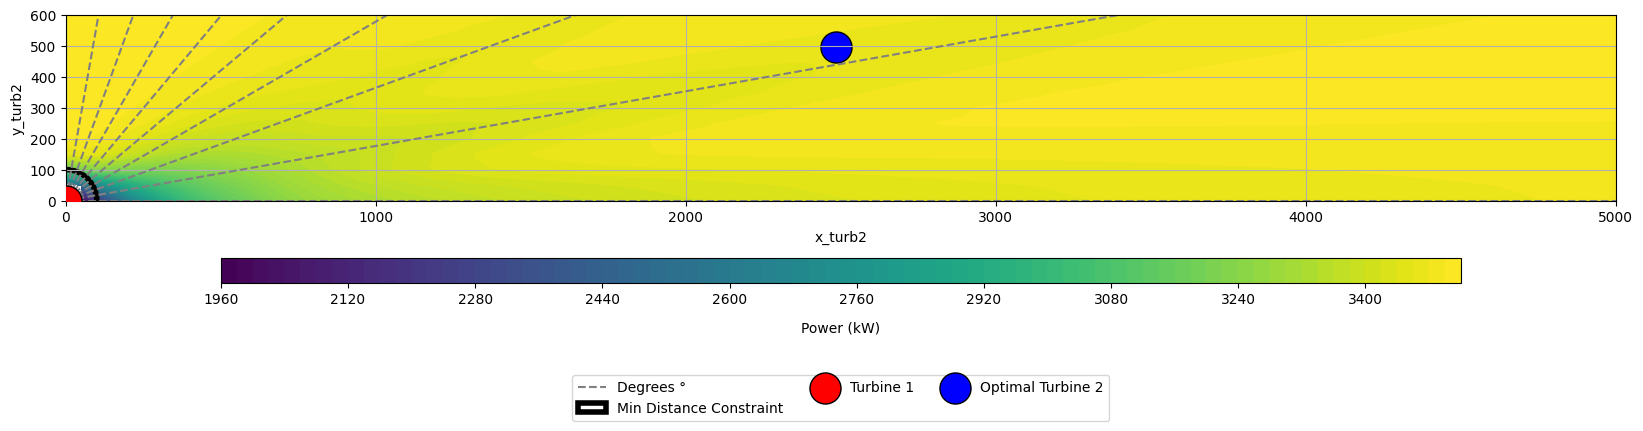

In [ ]:
# Visualize the results
from scipy.interpolate import griddata


# Colormap with interpolation
x = expected_power_by_location['x_turb2']
y = expected_power_by_location['y_turb2']
z = expected_power_by_location['prob_weighted_power']
xi, yi = np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100)
xi, yi = np.meshgrid(xi, yi)
zi = griddata((x, y), z, (xi, yi), method='linear')

plt.figure(figsize=(20, 6))
plt.contourf(xi, yi, zi, levels=100, cmap='viridis')
cbar = plt.colorbar(label='Expected Power Generated', orientation='horizontal', pad=-0.2, aspect=50, shrink=0.8)
cbar.ax.set_xlabel('Power (kW)', labelpad=10)

# Add angles
for i, angle in enumerate([0, 10, 20, 30, 40, 50, 60, 70, 80, 90]):
    radians = np.deg2rad(angle)
    label = f'Degrees °' if i == 0 else None  # Add label only to the first line
    plt.plot([0, 5000 * np.cos(radians)], [0, 5000 * np.sin(radians)], linestyle='--', color='gray', label=label)


# Plot minimum distance constraint
circle = plt.Circle((0, 0), 100, color='black', fill=False, linestyle='-', label='Min Distance Constraint', linewidth=4)
plt.gca().add_artist(circle)

# Turbine Positions
plt.scatter(0, 0, color='red', label='Turbine 1', s=500, edgecolor='black', zorder=10)
optimal_x = pyo.value(model.x['x_turb2',1])
optimal_y = pyo.value(model.x['y_turb2',1])
plt.scatter(optimal_x, optimal_y, color='blue', label='Optimal Turbine 2', s=500, edgecolor='black')

# Cosmetics
plt.axis('scaled')
plt.xlim(x.min(), x.max())
plt.ylim(y.min(), y.max())
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.9), ncol=3)
plt.xlabel('x_turb2')
plt.ylabel('y_turb2')
#plt.title('Colormap of Turbine 2 Power across x_turb2 and y_turb2 (Interpolated)')
plt.grid(True)
plt.show()
